In [18]:
# IMPORTANT: RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES,
# THEN FEEL FREE TO DELETE THIS CELL.
# NOTE: THIS NOTEBOOK ENVIRONMENT DIFFERS FROM KAGGLE'S PYTHON
# ENVIRONMENT SO THERE MAY BE MISSING LIBRARIES USED BY YOUR
# NOTEBOOK.
import kagglehub
jawadali1045_20k_multi_class_crop_disease_images_path = kagglehub.dataset_download('jawadali1045/20k-multi-class-crop-disease-images')

print('Data source import complete.')


Data source import complete.


In [39]:
jawadali1045_20k_multi_class_crop_disease_images_path

'/root/.cache/kagglehub/datasets/jawadali1045/20k-multi-class-crop-disease-images/versions/1'

In [19]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All"
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [20]:
!rm -rf /kaggle/working/*

In [21]:
!pip install imagehash
!pip install kagglehub
!pip install kaggle
!pip install torchinfo
!pip install seaborn


In [22]:
import os
import cv2
import imagehash
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from PIL import Image
from concurrent.futures import ProcessPoolExecutor

import torch
import torch.nn as nn
import torch.nn.functional as F
from torchinfo import summary
from torchvision import transforms, models, datasets
from torch.utils.data import Dataset, DataLoader, random_split
from torch.optim.lr_scheduler import ReduceLROnPlateau

from sklearn.metrics import recall_score, f1_score, roc_auc_score, confusion_matrix
from sklearn.preprocessing import label_binarize

In [23]:
corrupted = []
df_list = []

root_dir = '/kaggle/working/combined_dataset'

In [40]:
import os
import shutil

# Path ke direktori dataset Train dan Validation
train_dir = '/root/.cache/kagglehub/datasets/jawadali1045/20k-multi-class-crop-disease-images/versions/1/Train'
validation_dir = '/root/.cache/kagglehub/datasets/jawadali1045/20k-multi-class-crop-disease-images/versions/1/Validation'

# Folder tujuan untuk menyimpan semua gambar gabungan
destination_base_folder = '/kaggle/working/combined_dataset'

# Buat folder tujuan jika belum ada
os.makedirs(destination_base_folder, exist_ok=True)

# Fungsi untuk membaca gambar dari direktori dan menyalinnya ke folder tujuan dengan struktur yang sama
def copy_files_with_structure(source_directory, destination_base_folder):
    for root, dirs, files in os.walk(source_directory):
        for file in files:
            if file.endswith(('png', 'jpg', 'jpeg')):  # Filter file gambar
                source_file_path = os.path.join(root, file)
                relative_path = os.path.relpath(root, source_directory)
                destination_folder = os.path.join(destination_base_folder, relative_path)
                destination_file_path = os.path.join(destination_folder, file)

                # Buat folder tujuan jika belum ada
                os.makedirs(destination_folder, exist_ok=True)

                # Salin file
                shutil.copy2(source_file_path, destination_file_path)
                print(f"File {file} berhasil disalin ke {destination_file_path}.")

# Salin gambar dari folder Train dan Validation ke folder tujuan dengan struktur yang sama
copy_files_with_structure(train_dir, destination_base_folder)
copy_files_with_structure(validation_dir, destination_base_folder)

Streaming output truncated to the last 5000 lines.
File Corn_Health (554).jpg berhasil disalin ke /kaggle/working/combined_dataset/Healthy Maize/Corn_Health (554).jpg.
File Corn_Health (851).jpg berhasil disalin ke /kaggle/working/combined_dataset/Healthy Maize/Corn_Health (851).jpg.
File Corn_Health (2).jpg berhasil disalin ke /kaggle/working/combined_dataset/Healthy Maize/Corn_Health (2).jpg.
File Corn_Health (528).jpg berhasil disalin ke /kaggle/working/combined_dataset/Healthy Maize/Corn_Health (528).jpg.
File Corn_Health (703).jpg berhasil disalin ke /kaggle/working/combined_dataset/Healthy Maize/Corn_Health (703).jpg.
File Corn_Health (112).jpg berhasil disalin ke /kaggle/working/combined_dataset/Healthy Maize/Corn_Health (112).jpg.
File Corn_Health (330).jpg berhasil disalin ke /kaggle/working/combined_dataset/Healthy Maize/Corn_Health (330).jpg.
File Corn_Health (1024).jpg berhasil disalin ke /kaggle/working/combined_dataset/Healthy Maize/Corn_Health (1024).jpg.
File Corn_Healt

In [42]:
def process_image(image_path, animal):
    if not os.path.isfile(image_path):
        return [image_path, True, None, None, None, None, None, animal]

    img = cv2.imread(image_path)
    if img is None:
        return [image_path, True, None, None, None, None, None, animal]

    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img_pil = Image.fromarray(img_rgb)
    img_hash = imagehash.phash(img_pil)
    width, height, channels = img.shape
    image_format = os.path.splitext(image_path)[-1]

    return [image_path, False, img_hash, image_format, width, height, channels, animal]

In [43]:
def process_animal(animal_dir, animal):
    image_paths = [os.path.join(animal_dir, image) for image in os.listdir(animal_dir) if os.path.isfile(os.path.join(animal_dir, image))]

    with ProcessPoolExecutor() as executor:
        results = executor.map(process_image, image_paths, [animal] * len(image_paths))

    valid_results = []
    for result in results:
        if result:
            if result[1]:
                corrupted.append(result[0])
            valid_results.append(result)
    return valid_results

In [44]:
for animal in os.listdir(root_dir):
    animal_dir = os.path.join(root_dir, animal)
    if os.path.isdir(animal_dir):
        results = process_animal(animal_dir, animal)
        df_list.extend(results)

In [45]:
print(f'Total corrupted images: {len(corrupted)}\n'
      f'Corrupted Images:\n{corrupted}')

Total corrupted images: 0
Corrupted Images:
[]


In [46]:
df = pd.DataFrame(columns=['image_path', 'corrupted', 'image_hash', 'image_format', 'width', 'height', 'channels', 'label'], data = df_list)
df.head()

,image_path,corrupted,image_hash,image_format,width,height,channels,label
0,/kaggle/working/combined_dataset/bacterial_bli...,False,cfd82c1e7da84551,.jpg,428,571,3,bacterial_blight in Cotton
1,/kaggle/working/combined_dataset/bacterial_bli...,False,acc8e8e4d985d955,.png,173,153,3,bacterial_blight in Cotton
2,/kaggle/working/combined_dataset/bacterial_bli...,False,f178dea569c32189,.png,165,220,3,bacterial_blight in Cotton
3,/kaggle/working/combined_dataset/bacterial_bli...,False,a85752add1aaf50a,.jpg,333,500,3,bacterial_blight in Cotton
4,/kaggle/working/combined_dataset/bacterial_bli...,False,c1ca3f596ca82cd3,.jpg,683,1024,3,bacterial_blight in Cotton


In [47]:
df.describe().loc[['mean', 'std', 'min', 'max']]

,width,height,channels
mean,490.144291,479.341609,3.0
std,412.816607,417.908929,0.0
min,31.000000,36.000000,3.0
max,5504.000000,8256.000000,3.0


(array([0, 1, 2]),
 [Text(0, 0, '.jpg'), Text(1, 0, '.jpeg'), Text(2, 0, '.png')])

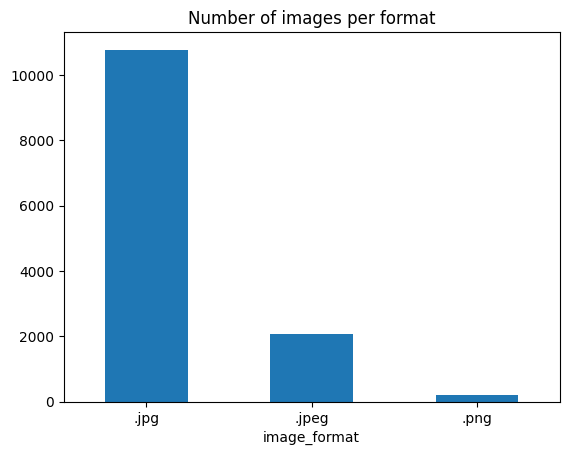

In [48]:
df['image_format'].value_counts().plot(kind='bar', title='Number of images per format')
plt.xticks(rotation=0)

In [49]:
class CONFIG:
    IMAGE_HEIGHT = 224
    IMAGE_WIDTH = 224
    CHANNELS = 3

    DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    N_CLASSES = df['label'].nunique()

    BATCH_SIZE = 16
    N_EPOCHS = 50
    PATIENCE_EPOCHS = 10
    LR = 0.001
    L2 = 0.0001
    DROPOUT = 0.3

    PATIENCE_SCHEDULER = 5

    MIN_VALUE_ACCURACY = 80

In [50]:
transform = transforms.Compose([
    transforms.Resize((CONFIG.IMAGE_HEIGHT, CONFIG.IMAGE_WIDTH)),
    transforms.ToTensor(),
    transforms.ColorJitter(brightness=0.3, contrast=0.2, saturation=0.2),
    transforms.RandomResizedCrop(224, scale=(0.8, 1.0), ratio=(0.9, 1.1)),
    transforms.RandomVerticalFlip(p=0.5),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

In [51]:
dataset = datasets.ImageFolder(root=root_dir, transform=transform)

train_size = int(0.7 * len(dataset))
val_size = int(0.15 * len(dataset))
test_size = len(dataset) - train_size - val_size
train_dataset, val_dataset, test_dataset = random_split(dataset, [train_size, val_size, test_size])

In [52]:
train_loader = DataLoader(train_dataset, batch_size=CONFIG.BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=CONFIG.BATCH_SIZE, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=CONFIG.BATCH_SIZE, shuffle=False)

In [53]:
model = models.efficientnet_b2(weights=models.EfficientNet_B2_Weights.DEFAULT)
model.classifier = nn.Sequential(
    nn.Dropout(
        p=CONFIG.DROPOUT,
        inplace=True
        ),
    nn.Linear(
        model.classifier[1].in_features,
        CONFIG.N_CLASSES,
        bias=True
        )
    )

Downloading: "https://download.pytorch.org/models/efficientnet_b2_rwightman-c35c1473.pth" to /root/.cache/torch/hub/checkpoints/efficientnet_b2_rwightman-c35c1473.pth
100%|██████████| 35.2M/35.2M [00:00<00:00, 156MB/s]


In [54]:
efficientnet = models.efficientnet_b2(weights=models.EfficientNet_B2_Weights.DEFAULT)

print(f'Default: {efficientnet.classifier}\n\n CustomModel: {model.classifier}')

Default: Sequential(
  (0): Dropout(p=0.3, inplace=True)
  (1): Linear(in_features=1408, out_features=1000, bias=True)
)

 CustomModel: Sequential(
  (0): Dropout(p=0.3, inplace=True)
  (1): Linear(in_features=1408, out_features=44, bias=True)
)


In [55]:
summary(model, input_size=(CONFIG.BATCH_SIZE, CONFIG.CHANNELS, CONFIG.IMAGE_HEIGHT, CONFIG.IMAGE_WIDTH))

Layer (type:depth-idx)                                  Output Shape              Param #
EfficientNet                                            [16, 44]                  --
├─Sequential: 1-1                                       [16, 1408, 7, 7]          --
│    └─Conv2dNormActivation: 2-1                        [16, 32, 112, 112]        --
│    │    └─Conv2d: 3-1                                 [16, 32, 112, 112]        864
│    │    └─BatchNorm2d: 3-2                            [16, 32, 112, 112]        64
│    │    └─SiLU: 3-3                                   [16, 32, 112, 112]        --
│    └─Sequential: 2-2                                  [16, 16, 112, 112]        --
│    │    └─MBConv: 3-4                                 [16, 16, 112, 112]        1,448
│    │    └─MBConv: 3-5                                 [16, 16, 112, 112]        612
│    └─Sequential: 2-3                                  [16, 24, 56, 56]          --
│    │    └─MBConv: 3-6                                

In [56]:
class EarlyStopping:
    def __init__(self, patience=0, verbose=False, min_delta=0, path="checkpoint.pth", min_val_acc=0):
        self.patience = patience
        self.verbose = verbose
        self.min_delta = min_delta
        self.path = path
        self.min_val_acc = min_val_acc
        self.counter = 0
        self.best_score = None
        self.early_stop = False

    def __call__(self, model, optimizer, scheduler, train_losses, val_losses, train_accuracies, val_accuracies, learning_rate, l2_norm, epochs):
        if val_accuracies[-1] < self.min_val_acc:
            if self.verbose:
                print(f"Validation accuracy {val_accuracies[-1]:.4f} did not reach minimum {self.min_val_acc:.4f}. Not saving.")
            return

        score = val_accuracies[-1]

        if self.best_score is None:
            self.best_score = score
            self.save_checkpoint(model, optimizer, scheduler, train_losses, val_losses, train_accuracies, val_accuracies, learning_rate, l2_norm, epochs)
        elif score < self.best_score + self.min_delta:
            self.counter += 1
            if self.verbose:
                print(f"EarlyStopping counter: {self.counter} out of {self.patience}")
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_score = score
            self.save_checkpoint(model, optimizer, scheduler, train_losses, val_losses, train_accuracies, val_accuracies, learning_rate, l2_norm, epochs)
            self.counter = 0

    def save_checkpoint(self, model, optimizer, scheduler, train_losses, val_losses, train_accuracies, val_accuracies, learning_rate, l2_norm, epochs):
        if self.verbose:
            print(f"Validation accuracy improved. Saving model with val_loss {val_losses[-1]:.6f}...")

        training_state = {
            "model_state_dict": model.state_dict(),
            "optimizer_state_dict": optimizer.state_dict(),
            "scheduler_state_dict": scheduler.state_dict() if scheduler else None,
            "train_losses": train_losses,
            "val_losses": val_losses,
            "train_accuracies": train_accuracies,
            "val_accuracies": val_accuracies,
            "hyperparameters": {
                "learning_rate": learning_rate,
                "L2 norm": l2_norm,
                "batch_size": 32,
                "epochs": epochs,
            }
        }
        torch.save(training_state, self.path)

In [57]:
criterion = nn.CrossEntropyLoss()

optimizer = torch.optim.Adam(model.parameters(), lr=CONFIG.LR, weight_decay=CONFIG.L2)

scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=CONFIG.PATIENCE_SCHEDULER)

In [58]:
def train_model(model, data_loader, criterion, optimizer, device):
    model.train()
    train_loss, train_correct, train_total = 0, 0, 0
    for inputs, labels in data_loader:
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        train_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        train_correct += (predicted == labels).sum().item()
        train_total += labels.size(0)

    avg_loss = train_loss / len(data_loader)
    train_accuracy = 100 * train_correct / train_total

    return avg_loss, train_accuracy

In [59]:
def evaluate_model(model, data_loader, criterion, device):
    model.eval()
    val_loss, val_correct, val_total = 0, 0, 0
    with torch.no_grad():
        for inputs, labels in data_loader:
            inputs, labels = inputs.to(device), labels.to(device)

            outputs = model(inputs)
            loss = criterion(outputs, labels)
            val_loss += loss.item()

            _, predicted = torch.max(outputs.data, 1)
            val_correct += (predicted == labels).sum().item()
            val_total += labels.size(0)

    avg_loss = val_loss / len(data_loader)
    val_accuracy = 100 * val_correct / val_total

    scheduler.step(val_loss)
    current_lr = scheduler.get_last_lr()[0]

    return avg_loss, val_accuracy, current_lr

In [60]:
train_accuracies = []
val_accuracies = []
train_losses = []
val_losses = []

early_stopping = EarlyStopping(patience=CONFIG.PATIENCE_EPOCHS, verbose=True, min_val_acc=CONFIG.MIN_VALUE_ACCURACY, path="best_model.pth")

for epoch in range(CONFIG.N_EPOCHS):
    train_loss, train_accuracy = train_model(model, train_loader, criterion, optimizer, CONFIG.DEVICE)
    val_loss, val_accuracy, current_lr = evaluate_model(model, val_loader, criterion, CONFIG.DEVICE)

    train_losses.append(train_loss)
    val_losses.append(val_loss)
    train_accuracies.append(train_accuracy)
    val_accuracies.append(val_accuracy)

    print(f"Epoch {epoch+1}/{CONFIG.N_EPOCHS}")
    print(f"Train Loss: {train_loss:.4f} | Train Accuracy: {train_accuracy:.2f}%")
    print(f"Validation Loss: {val_loss:.4f} | Validation Accuracy: {val_accuracy:.2f}%")
    print(f"Learning Rate: {current_lr}")

    early_stopping(model, optimizer, scheduler, train_losses, val_losses, train_accuracies, val_accuracies, CONFIG.LR, CONFIG.L2, CONFIG.N_EPOCHS)
    if early_stopping.early_stop:
        print("Early stopping activated. Stopping training.")
        break

/usr/local/lib/python3.11/dist-packages/PIL/TiffImagePlugin.py:949: UserWarning: Corrupt EXIF data.  Expecting to read 4 bytes but only got 0. 
  warnings.warn(str(msg))
/usr/local/lib/python3.11/dist-packages/PIL/Image.py:1045: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Epoch 1/50
Train Loss: 1.0619 | Train Accuracy: 72.08%
Validation Loss: 0.6445 | Validation Accuracy: 83.33%
Learning Rate: 0.001
Validation accuracy improved. Saving model with val_loss 0.644461...
Epoch 2/50
Train Loss: 0.5673 | Train Accuracy: 84.01%
Validation Loss: 0.4556 | Validation Accuracy: 88.60%
Learning Rate: 0.001
Validation accuracy improved. Saving model with val_loss 0.455553...
Epoch 3/50
Train Loss: 0.4548 | Train Accuracy: 87.08%
Validation Loss: 0.4897 | Validation Accuracy: 87.18%
Learning Rate: 0.001
EarlyStopping counter: 1 out of 10
Epoch 4/50
Train Loss: 0.3990 | Train Accuracy: 88.03%
Validation Loss: 0.4304 | Validation Accuracy: 88.70%
Learning Rate: 0.001
Validation accuracy improved. Saving model with val_loss 0.430402...
Epoch 5/50
Train Loss: 0.3911 | Train Accuracy: 88.57%
Validation Loss: 0.3816 | Validation Accuracy: 89.31%
Learning Rate: 0.001
Validation accuracy improved. Saving model with val_loss 0.381586...
Epoch 6/50
Train Loss: 0.3518 | Train A

KeyboardInterrupt: 

In [63]:
import torch
from torchvision import models
import torch.nn as nn

# Load EfficientNet-B2 architecture without pre-trained weights
model = models.efficientnet_b2(weights=None)

# Modify classifier to match trained architecture
model.classifier = nn.Sequential(
    nn.Dropout(p=CONFIG.DROPOUT, inplace=True),
    nn.Linear(model.classifier[1].in_features, CONFIG.N_CLASSES, bias=True)
)

# Load the checkpoint and extract only the model state_dict
checkpoint = torch.load("best_model.pth", map_location=torch.device("cpu"))
model.load_state_dict(checkpoint["model_state_dict"])  # Correct way to load weights
model.eval()  # Set model to evaluation mode

print("Model successfully loaded and ready for inference!")


Model successfully loaded and ready for inference!


In [64]:
# Convert to TorchScript for optimized inference
scripted_model = torch.jit.script(model)
scripted_model.save("efficientnet_b2_scripted.pt")

In [66]:
# Load checkpoint
checkpoint = torch.load("best_model.pth", map_location=torch.device("cpu"))

# Get class-to-index mapping (if saved)
if "class_to_idx" in checkpoint:
    class_to_idx = checkpoint["class_to_idx"]
    idx_to_class = {v: k for k, v in class_to_idx.items()}  # Reverse mapping
    class_names = list(idx_to_class.values())
    print(class_names)
else:
    print("Class information not saved in the checkpoint.")



Class information not saved in the checkpoint.
